In [1]:
import numpy as np
import imageio
from typing import Tuple
from mip.display.image import show, read, subplot_images
import matplotlib.pyplot as plt
from scipy.ndimage import convolve  

In [6]:
def createGaussianBlurringOperator(size_I, hsize, sigma):
    """
    Creates an operator for blurring with a Gaussian kernel of size 'hsize' and standard deviation 'sigma'.
    
    Parameters:
    size_I (tuple): Size of the image (height, width).
    hsize (int): Size of the Gaussian kernel.
    sigma (float): Standard deviation of the Gaussian kernel.
    
    Returns:
    Op (function): Blurring operator.
    Op_adj (function): Adjoint of the blurring operator.
    fftFilter (numpy.ndarray): FFT of the Gaussian kernel.
    """
    # Create Gaussian kernel
    kernel = np.outer(
        np.exp(-np.linspace(-(hsize//2), hsize//2, hsize)**2 / (2*sigma**2)),
        np.exp(-np.linspace(-(hsize//2), hsize//2, hsize)**2 / (2*sigma**2))
    )
    kernel /= np.sum(kernel)
    
    # Initialize FFT filter with zeros and place the kernel in the top-left corner
    fftFilter = np.zeros(size_I)
    fftFilter[:kernel.shape[0], :kernel.shape[1]] = kernel
    
    # Center the kernel
    fftFilter = np.roll(fftFilter, -kernel.shape[0]//2 + 1, axis=0)
    fftFilter = np.roll(fftFilter, -kernel.shape[1]//2 + 1, axis=1)
    
    # Compute the FFT of the kernel and its conjugate
    fftFilter = np.fft.fftn(fftFilter)
    fftFilterC = np.conj(fftFilter)
    
    # Define the operators
    Op = lambda x: np.fft.ifftn(np.fft.fftn(x) * fftFilter).real
    Op_adj = lambda y: np.fft.ifftn(np.fft.fftn(y) * fftFilterC).real
    
    return Op, Op_adj, fftFilter

In [14]:
def deconv_van_cittert(f: np.ndarray, k_A: np.ndarray, iterations: int):
    titles = []
    images = []
    u = f.copy()
    q = 1 - k_A
    for i in range(iterations):
        u = f + np.fft.ifft2(np.fft.fft2(u) * q).real
        if (i+1) % 3 == 0:
            titles.append(f"Deconvolved at iteration: {i+1}")
            images.append(u)
    return titles, images

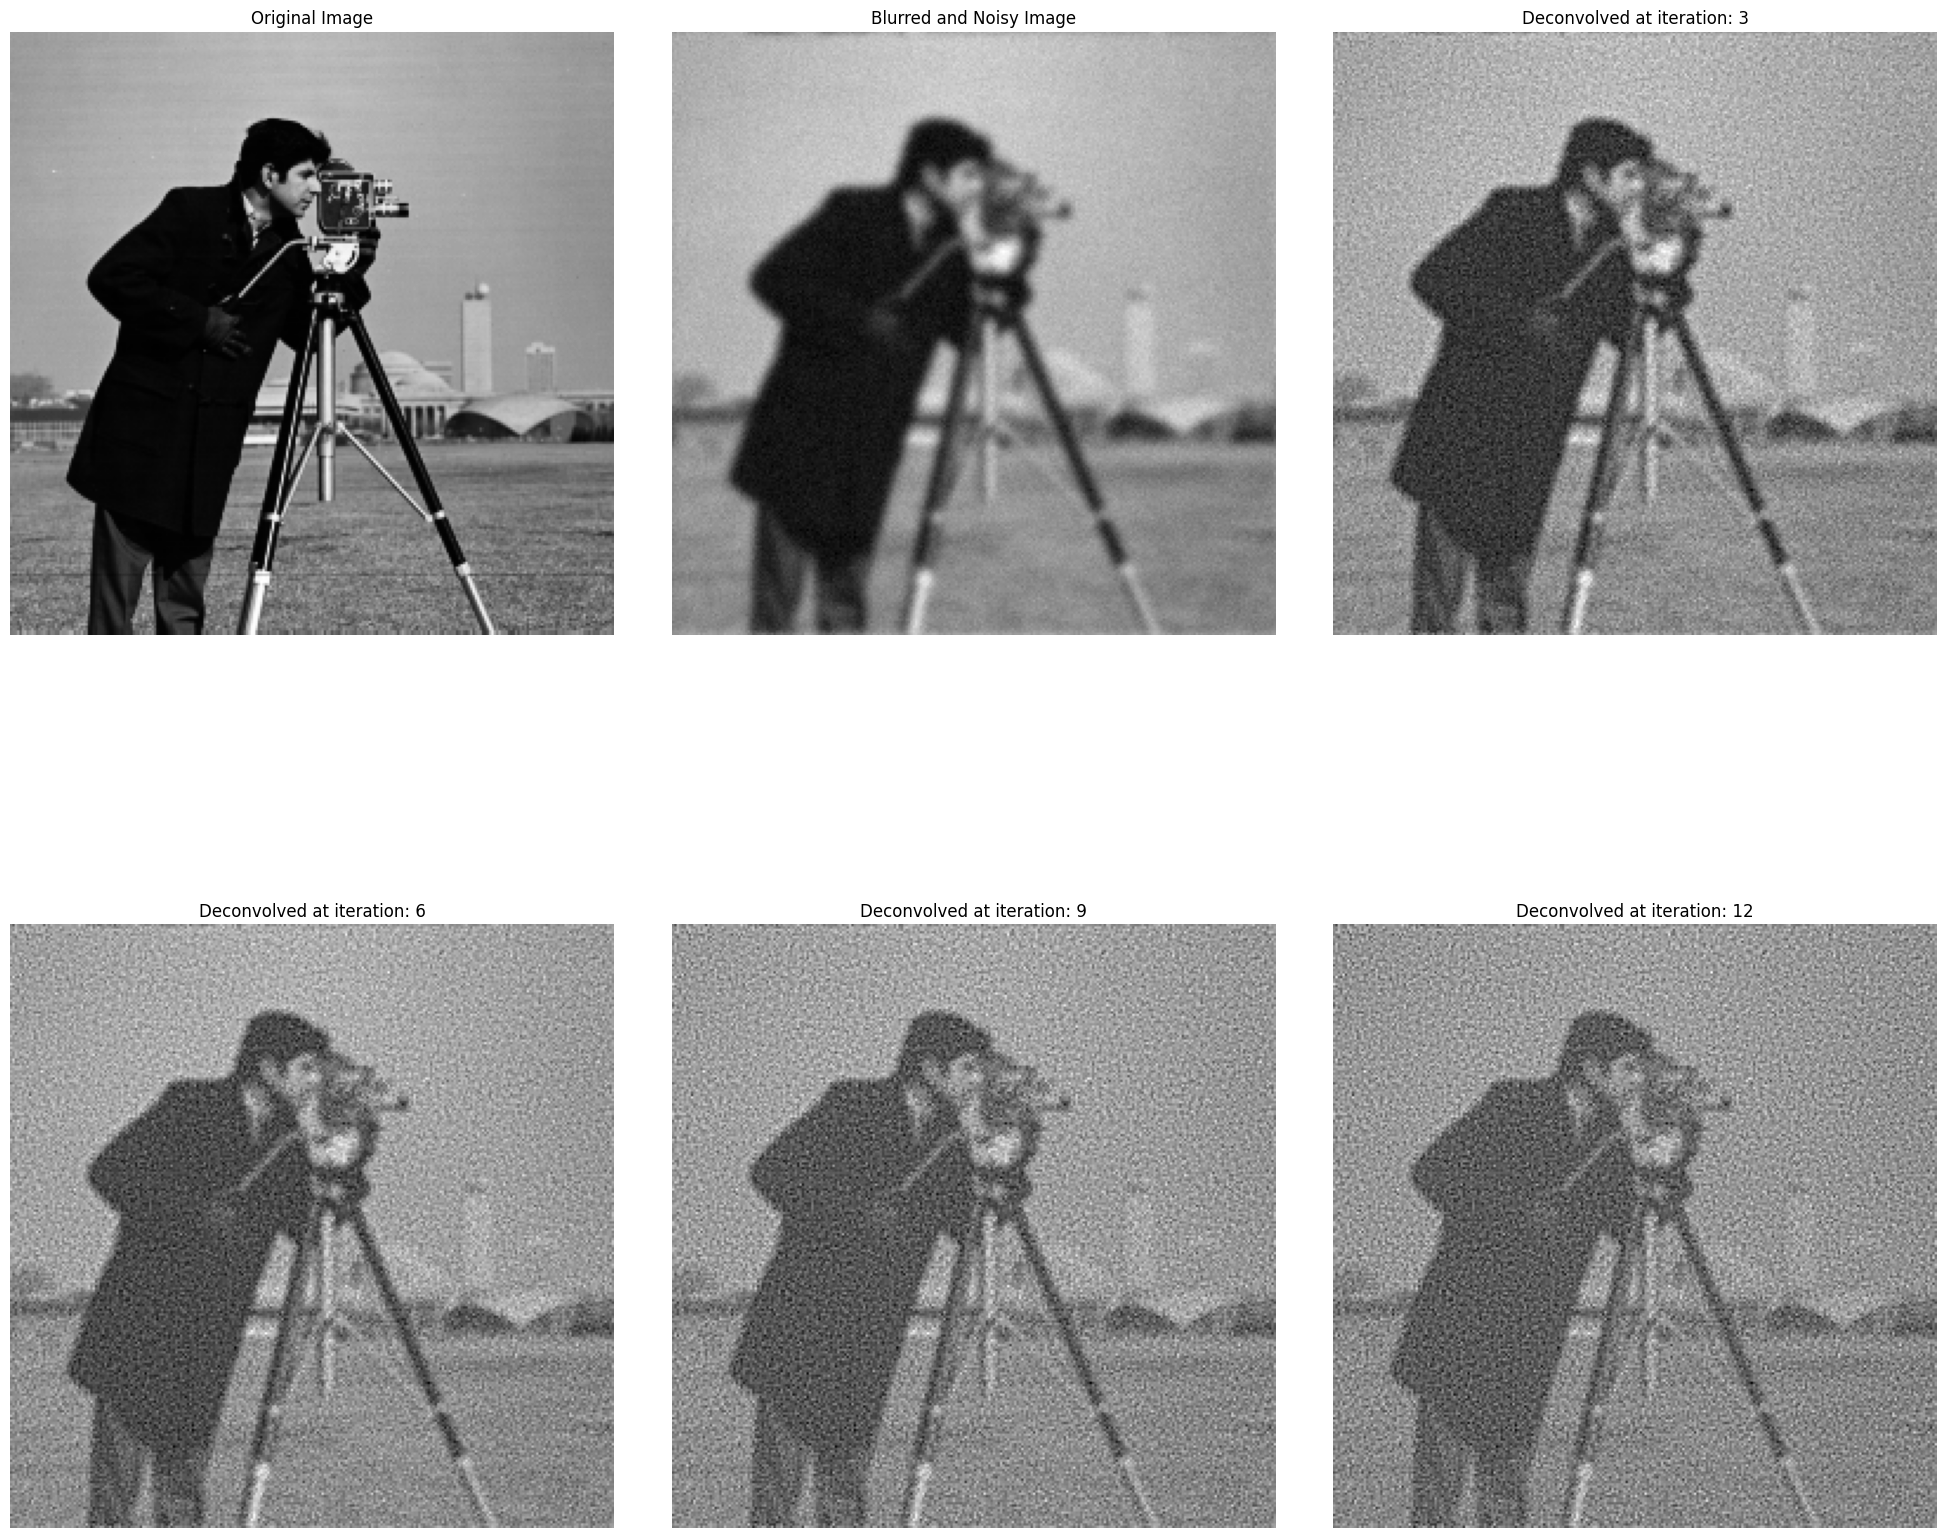

In [15]:
I = read("../assets/cameraman.png", "GRAY")
I = I.astype(np.float64)

k = 5
gamma = 2 * k + 1 # size of kernel
sigma = 2
iterations = 15

# Blurring and adding noise
Op, Op_adj, kA = createGaussianBlurringOperator(I.shape, gamma, sigma)
I_nse = Op(I) + 5 * np.random.randn(*I.shape)

# Deconvolution
titles, images = deconv_van_cittert(I_nse, kA, iterations)

images.insert(0, I)
images.insert(1, I_nse)
titles.insert(0, "Original Image")
titles.insert(1, "Blurred and Noisy Image")

subplot_images(
    images, titles=titles, fig_size=(20, 18), order=(-1, 3), dpi=100
).savefig("../exercise_solutions/ex4/deconv_vanCittert.png")

plt.show()